%matplotlib inline
%load_ext autoreload
%autoreload 2

In [29]:
import numpy as np
import numpy.random as npr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec  # Import for custom grid layout
from scipy import stats
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


from notebooks.imports import *
from config import dir_config, main_config
from src.utils import pmf_utils, plot_utils


In [2]:
compiled_dir = Path(dir_config.data.compiled)
processed_dir = Path(dir_config.data.processed)

## Utils

In [ ]:
def extract_neuronal_data(alignment, data_type="convolved_spike_trains"):
    neuronal_data = {
        'biased_state': {},
        'unbiased_state': {},
    }
    
    for idx, neuron_id in enumerate(neuron_metadata.neuron_id):
        session_id = neuron_metadata.session_id[idx]
        biased_trials = np.array(state_occupancy["210126_GP_JP"]["biased_state_trials"])
        biased_idx = np.where(np.isin(np.array(ephys[alignment][neuron_id]["trial_number"]), biased_trials))[0]
        unbiased_trials = np.array(state_occupancy["210126_GP_JP"]["unbiased_state_trials"])
        unbiased_idx = np.where(np.isin(np.array(ephys[alignment][neuron_id]["trial_number"]), unbiased_trials))[0]
        
        neuronal_data['biased_state'][neuron_id] = np.array(ephys[alignment][neuron_id][data_type][biased_idx])
        neuronal_data['unbiased_state'][neuron_id] = np.array(ephys[alignment][neuron_id][data_type][unbiased_idx])
    
    return neuronal_data

def normalize_neuronal_data(data):
    for idx, neuron_id in enumerate(neuron_metadata.neuron_id):
        scaler = StandardScaler()
        data["biased_state"][neuron_id] = scaler.fit_transform(data["biased_state"][neuron_id])
        data["unbiased_state"][neuron_id] = scaler.fit_transform(data["unbiased_state"][neuron_id])
    return data

def get_trial_num(trial_data, coherence, choice, outcome=None):
    if outcome == 1:
        idx = (np.abs(trial_data.stimulus) == coherence) & (trial_data.choices == choice) & (trial_data["stimulus"] * (trial_data["choices"]*2-1) > 0)
    elif outcome == 0:
        idx = (np.abs(trial_data.stimulus) == coherence) & (trial_data.choices == choice) & (trial_data["stimulus"] * (trial_data["choices"]*2-1) < 0)
    else:
        idx = (np.abs(trial_data.stimulus) == coherence) & (trial_data.choices == choice)
    return np.array(trial_data["trial_num"][idx].values.reshape(-1, 1))

def get_neural_data_from_trial_num(neuronal_data, trial_num, type = "convolved_spike_trains"):
    index = np.where(np.isin(np.array(neuronal_data["trial_number"]), trial_num))[0]
    if type == "spike_trains":
        return np.array(neuronal_data["spike_trains"][index])
    elif type == "convolved_spike_trains":
        return np.array(neuronal_data["convolved_spike_trains"][index])

## Load Data

In [ ]:
session_metadata = pd.read_csv(Path(compiled_dir, 'sessions_metadata.csv'))
neuron_metadata = pd.read_csv(Path(compiled_dir, 'neuron_metadata.csv'))

with open(Path(processed_dir, f'glm_hmm_all_trials_prior_based_initialization_final.pkl'), 'rb') as f:
    glm_hmm = pickle.load(f)
    
with open(Path(processed_dir, f'ephys_neuron_wise.pkl'), 'rb') as f:
    ephys = pickle.load(f)

## Extract biased and unbiased states

In [18]:
bias_weights = []
state_occupancy = {}
for idx_session, session_id in enumerate(glm_hmm["session_wise"]["data"]):
    model = glm_hmm["session_wise"]["models"][session_id]
    glm_weights = -np.array(model.observations.params).reshape(2, -1)
    prior_direction = 1 if glm_hmm["session_wise"]["data"][session_id]["prob_toRF"].iloc[-1] > 50 else -1
    glm_weights[:,1] = glm_weights[:,1]*prior_direction
    if prior_direction == -1:
        glm_weights = np.flip(glm_weights, axis=0)
    bias_weights.append(glm_weights[:,1])
    
    
    choices = glm_hmm["session_wise"]["data"][session_id]["choices"].values.reshape(-1, 1)
    input = np.array(glm_hmm["session_wise"]["data"][session_id][["normalized_stimulus","bias","previous_choice","previous_target"]])
    if glm_hmm["session_wise"]["data"][session_id]["mask"] is None:
        mask = None
    else:
        mask = glm_hmm["session_wise"]["data"][session_id]["mask"]
    mask = np.ones_like(choices, dtype=bool) if mask is None else mask
    
    posterior_probs = model.expected_states(data=glm_hmm["session_wise"]["data"][session_id]["choices"].values.reshape(-1, 1), input=input, mask=np.array(mask).reshape(-1,1))[0]
    
    
bias_weights = np.array(bias_weights)

In [19]:
state_occupancy = {}
for idx_session, session_id in enumerate(glm_hmm["session_wise"]["data"]):
    model = glm_hmm["session_wise"]["models"][session_id]   
    choices = glm_hmm["session_wise"]["data"][session_id]["choices"].values.reshape(-1, 1)
    input = np.array(glm_hmm["session_wise"]["data"][session_id][["normalized_stimulus","bias","previous_choice","previous_target"]])
    if glm_hmm["session_wise"]["data"][session_id]["mask"] is None:
        mask = None
    else:
        mask = glm_hmm["session_wise"]["data"][session_id]["mask"]
    mask = np.ones_like(choices, dtype=bool) if mask is None else mask
    
    posterior_probs = model.expected_states(data=choices, input=input, mask=np.array(mask).reshape(-1,1))[0]
    biased_idx = (posterior_probs[:, 1] > 0.5) & np.array(mask)
    unbiased_idx = (posterior_probs[:, 0] > 0.5) & np.array(mask)
    state_occupancy[session_id] = {
        "biased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][biased_idx],
        "unbiased_state_trials": glm_hmm["session_wise"]["data"][session_id]["trial_num"][unbiased_idx]}
    

## Ephys!!!

In [49]:
target_onset = extract_neuronal_data("target_onset")
stimulus_onset = extract_neuronal_data("stimulus_onset")
response_onset = extract_neuronal_data("response_onset")

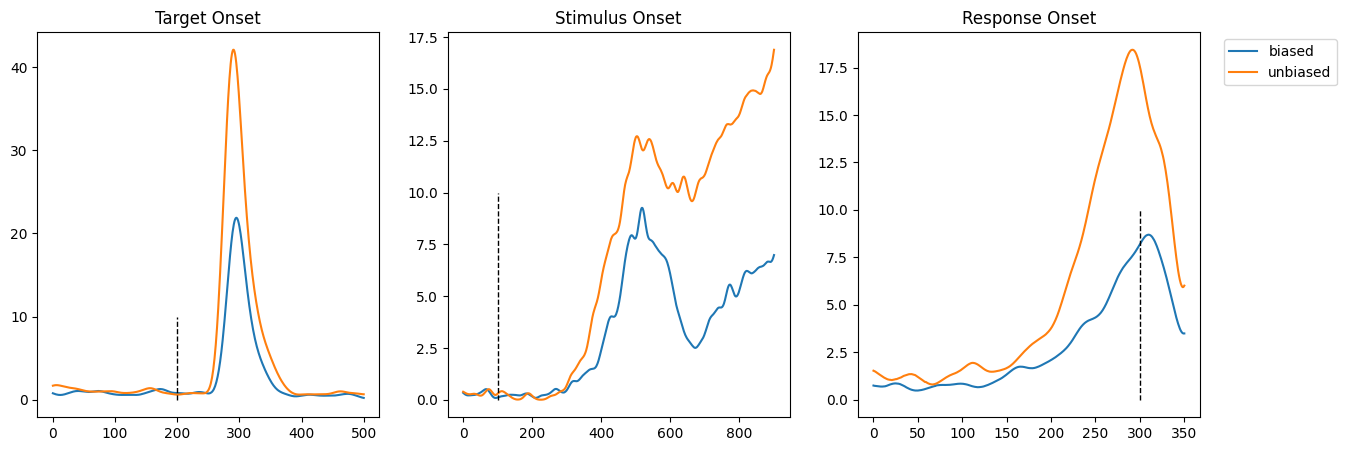

In [51]:
neuron_id = 170

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(np.nanmean(target_onset["biased_state"][neuron_id], axis=0), label="biased")
ax[0].plot(np.nanmean(target_onset["unbiased_state"][neuron_id], axis=0), label="unbiased")
ax[0].vlines(200, 0, 10, color="black", linestyle="--", linewidth=1)
ax[1].plot(np.nanmean(stimulus_onset["biased_state"][neuron_id], axis=0), label="biased")
ax[1].plot(np.nanmean(stimulus_onset["unbiased_state"][neuron_id], axis=0), label="unbiased")
ax[1].vlines(100, 0, 10, color="black", linestyle="--", linewidth=1)
ax[2].plot(np.nanmean(response_onset["biased_state"][neuron_id], axis=0), label="biased")
ax[2].plot(np.nanmean(response_onset["unbiased_state"][neuron_id], axis=0), label="unbiased")
ax[2].vlines(300, 0, 10, color="black", linestyle="--", linewidth=1)
ax[0].set_title("Target Onset")
ax[1].set_title("Stimulus Onset")
ax[2].set_title("Response Onset")
ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Normalization of Neural Data

In [ ]:
# target_onset = normalize_neuronal_data(target_onset)
# stimulus_onset = normalize_neuronal_data(stimulus_onset)
# response_onset = normalize_neuronal_data(response_onset)

## PCA

In [63]:
toRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "toRF"]
awayRF_sessions = session_metadata["session_id"][session_metadata.prior_direction == "awayRF"]

#### Preprocessing for PCA

In [ ]:
# compile into N X ct, where N is the number of neurons and c is number of conditions and t is the number of time points

fnsefsnefesnfs/oelfn

In [ ]:
# toRF sessions
pca = PCA(n_components=10)
target_onset_pca = {'biased_state': {}, 'unbiased_state': {}}
stimulus_onset_pca = {'biased_state': {}, 'unbiased_state': {}}
response_onset_pca = {'biased_state': {}, 'unbiased_state': {}}
for idx, session_id in enumerate(toRF_sessions):
    
    for idx, neuron_id in enumerate(neuron_metadata.neuron_id):

In [156]:
idx = 0
session_id, neuron_id = neuron_metadata.session_id[idx], neuron_metadata.neuron_id[idx]

trial_num = get_idx(glm_hmm["session_wise"]["data"][session_id], 0.2, 1, 0)
neuronal_data = ephys['stimulus_onset'][neuron_id]

In [ ]:
get_neural_data_from_trial_num(neuronal_data, trial_num)

array([[ 0.793353  ,  0.59661275,  0.44419706, ...,  0.        ,
         0.        ,  0.        ],
       [50.705303  , 50.742844  , 51.311886  , ...,  0.        ,
         0.        ,  0.        ],
       [ 3.5555613 ,  2.8391733 ,  2.2445676 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [19.462955  , 21.834972  , 24.252338  , ...,  0.        ,
         0.        ,  0.        ],
       [65.082726  , 62.613674  , 60.289684  , ...,  0.        ,
         0.        ,  0.        ],
       [60.017937  , 61.105335  , 61.956814  , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

TypeError: unsupported operand type(s) for /: 'dict' and 'int'